In [47]:
from tvl_enc.tvl import TVL, ModalityType
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Set device to GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
import timm
import re

model_names = timm.list_models()
for name in model_names:
    if re.match(r'^vit', name):
        print(name)


vit_base_patch8_224
vit_base_patch14_dinov2
vit_base_patch16_18x2_224
vit_base_patch16_224
vit_base_patch16_224_miil
vit_base_patch16_384
vit_base_patch16_clip_224
vit_base_patch16_clip_384
vit_base_patch16_gap_224
vit_base_patch16_plus_240
vit_base_patch16_rpn_224
vit_base_patch16_xp_224
vit_base_patch32_224
vit_base_patch32_384
vit_base_patch32_clip_224
vit_base_patch32_clip_384
vit_base_patch32_clip_448
vit_base_patch32_plus_256
vit_base_r26_s32_224
vit_base_r50_s16_224
vit_base_r50_s16_384
vit_base_resnet26d_224
vit_base_resnet50d_224
vit_giant_patch14_224
vit_giant_patch14_clip_224
vit_giant_patch14_dinov2
vit_gigantic_patch14_224
vit_gigantic_patch14_clip_224
vit_gigantic_patch16_224_ijepa
vit_huge_patch14_224
vit_huge_patch14_224_ijepa
vit_huge_patch14_clip_224
vit_huge_patch14_clip_336
vit_huge_patch14_xp_224
vit_huge_patch16_448_ijepa
vit_large_patch14_224
vit_large_patch14_clip_224
vit_large_patch14_clip_336
vit_large_patch14_dinov2
vit_large_patch14_xp_224
vit_large_patch16_

### To plot the result

In [49]:
def plot_prob(image_path, texts, probs):
    # Visualize the image and similarity scores with a horizontal bar chart
    plt.figure(figsize=(15, 5))
    ax_img = plt.subplot(1, 2, 1)

    # Display the image on the left
    img = Image.open(image_path)
    ax_img.imshow(img)
    ax_img.axis('off')  # Hide axis for image

    # Create a new figure for the bar chart (on the right)
    ax_img = plt.subplot(1, 2, 2)

    # Plot similarity probabilities for each text label
    y_pos = np.arange(len(texts))
    ax_img.barh(y_pos, probs, color='skyblue')
    ax_img.set_yticks(y_pos)
    ax_img.set_yticklabels(texts)
    ax_img.invert_yaxis()  # Highest probability on top
    ax_img.set_xlabel('Similarity Probability')
    ax_img.set_title('Vision/tatile-to-Text Similarity')

    # Display both plots
    plt.tight_layout()
    plt.show()

### Load the encoder model and CLIP model in TVL_enc.tvl
* Use CLIP model for vision and text.
    ```
    CLIP_VISION_MODEL = "ViT-L-14"
    CLIP_PRETRAIN_DATA = "datacomp_xl_s13b_b90k"
    ```
*  `tactile_model="vit_tiny_patch16_224"`
* Do inference.

In [50]:
MODEL_IDX = 1 # select below model
model_list = {
    "vit_tiny_patch16_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vittiny.pth",
    "vit_small_patch16_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vits.pth",
    "vit_base_patch16_224":r"D:\NSYSU_Fourth_grade\ADV_ML_Final_Project\checkpoints\tvl_enc_vitb.pth" # 2nd good
}
# Create TVL model instance with active modalities
model_tvl = TVL(
    active_modalities=[ModalityType.VISION, ModalityType.TACTILE, ModalityType.TEXT],
    tactile_model=list(model_list.keys())[MODEL_IDX]
).to(device)
model_tvl.eval()

# Load tactile encoder checkpoint
ckpt_path = list(model_list.values())[MODEL_IDX]
state_dict = torch.load(ckpt_path, map_location=device, weights_only=False)
model_tvl.load_state_dict(state_dict, strict=False)

# Load vision preprocessing transform (from OpenCLIP)
vision_preprocess = model_tvl.vision_preprocess

In [51]:
def inference_on_image(tactile_image_path, image_path, texts, model_tvl):
    # Load and preprocess tactile and vision images
    tactile_image = vision_preprocess(Image.open(tactile_image_path)).unsqueeze(0).to(device)
    vision_image  = vision_preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Tokenize text descriptions
    text_tokens = model_tvl.tokenizer(texts).to(device)

    # Prepare input dictionary for the model
    input_dict = {
        ModalityType.TACTILE: tactile_image,
        ModalityType.VISION: vision_image,
        ModalityType.TEXT: text_tokens
    }

    # Perform forward pass without gradient computation
    with torch.no_grad():
        output = model_tvl(input_dict)

    # Extract modality features and logit scale from the output
    tactile_feature = output[ModalityType.TACTILE]   # (1, dim)
    vision_features = output[ModalityType.VISION]    # (1, dim)
    text_features   = output[ModalityType.TEXT]      # (4, dim)
    logit_scale     = output["logit_scale"]          # scalar

    # Compute similarity logits between vision features and text features
    logit_scale = logit_scale.to(vision_features.device)
    logits_per_image = logit_scale * vision_features @ text_features.t()  # (1, 4)
    logits_per_text  = logits_per_image.t()                               # (4, 1)

    # Convert logits to probabilities using softmax
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    plot_prob(image_path, texts, probs)

    # Compute similarity logits between tactile features and text features
    logit_scale = logit_scale.to(tactile_feature.device)
    logits_per_image = logit_scale * tactile_feature @ text_features.t()  # (1, 4)
    logits_per_text  = logits_per_image.t()                               # (4, 1)

    # Convert logits to probabilities using softmax
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().flatten()

    plot_prob(tactile_image_path, texts, probs)

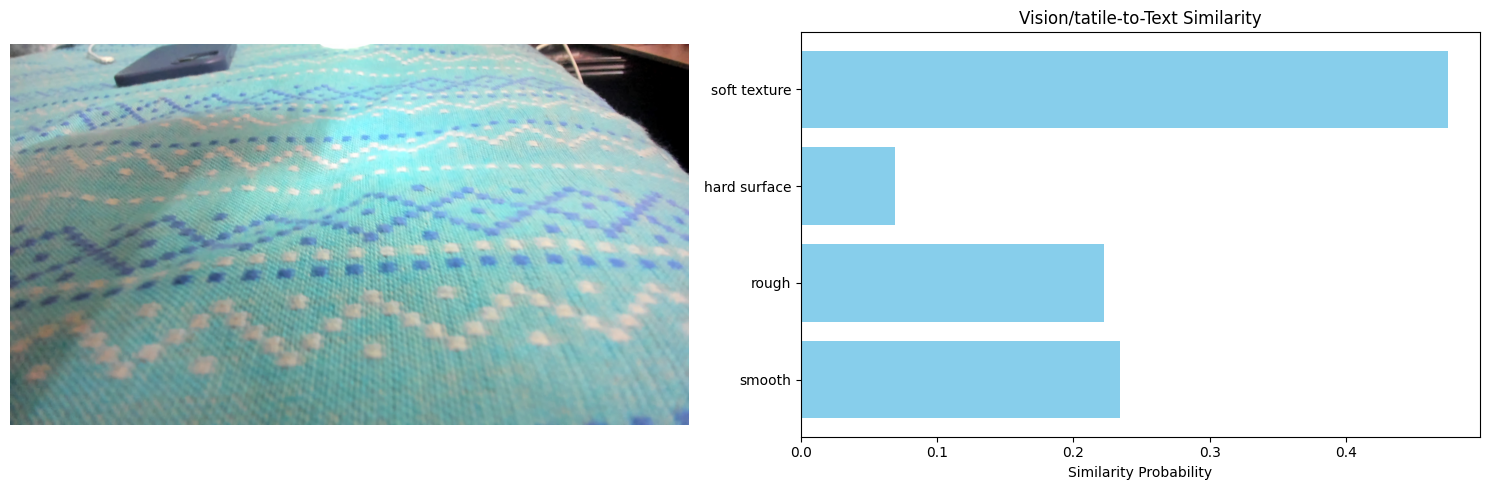

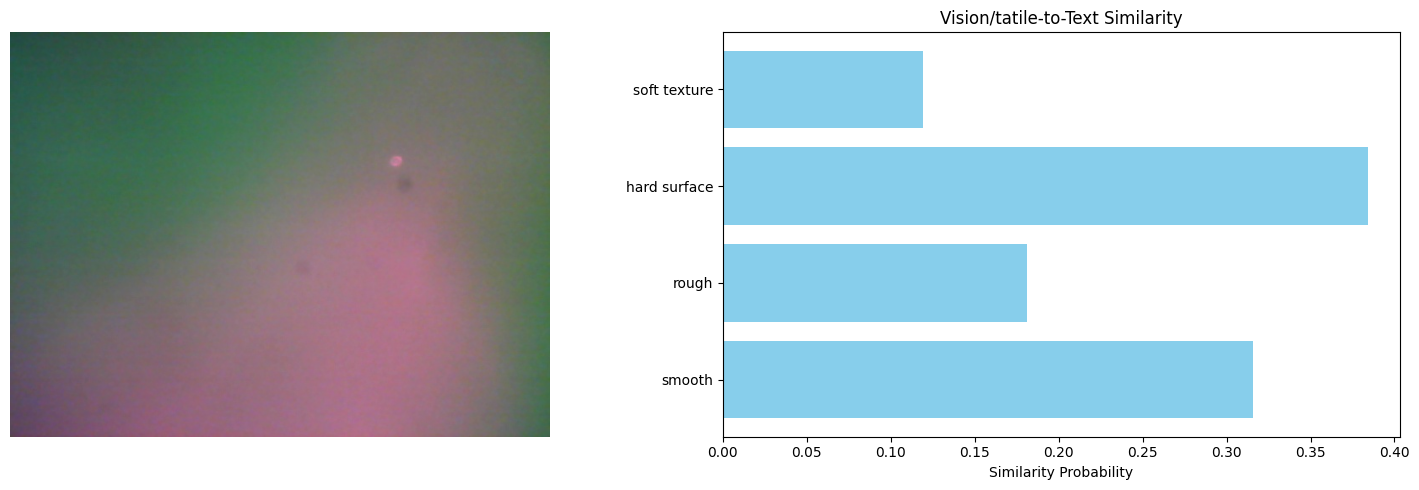

In [52]:
IMAGE_NAME = '93-0.0398557186126709'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Define text labels, use all texts as text input for inference, to see which cosine similarity is the max.
texts = ["soft texture", "hard surface", "rough", "smooth"]
# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, texts, model_tvl)

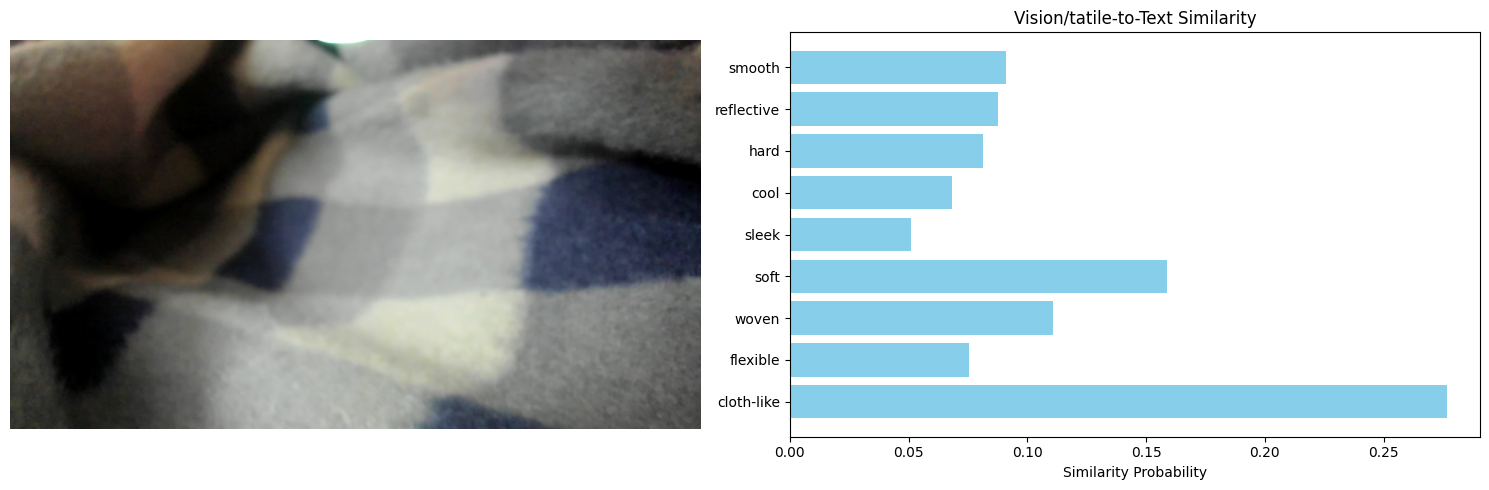

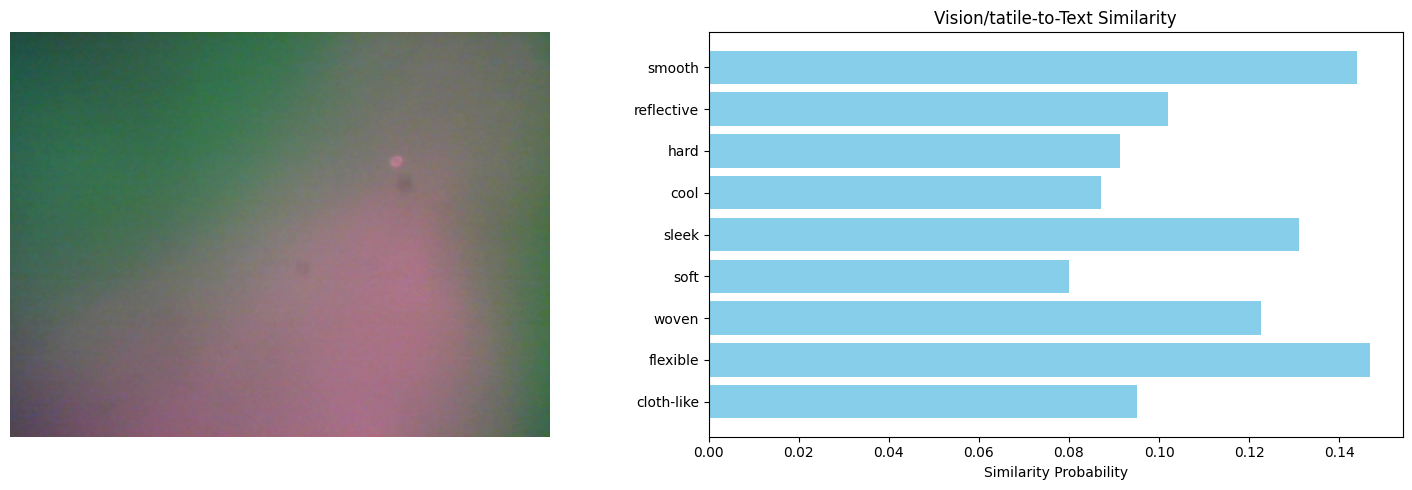

In [53]:
IMAGE_NAME = '65-0.03529810905456543'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Define text labels, use all texts as text input for inference, to see which cosine similarity is the max.
# texts = ["soft texture", "hard surface", "rough", "smooth"]
texts = ["smooth", "reflective", "hard", "cool", "sleek", "soft", "woven", "flexible", "cloth-like"]
# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, texts, model_tvl)

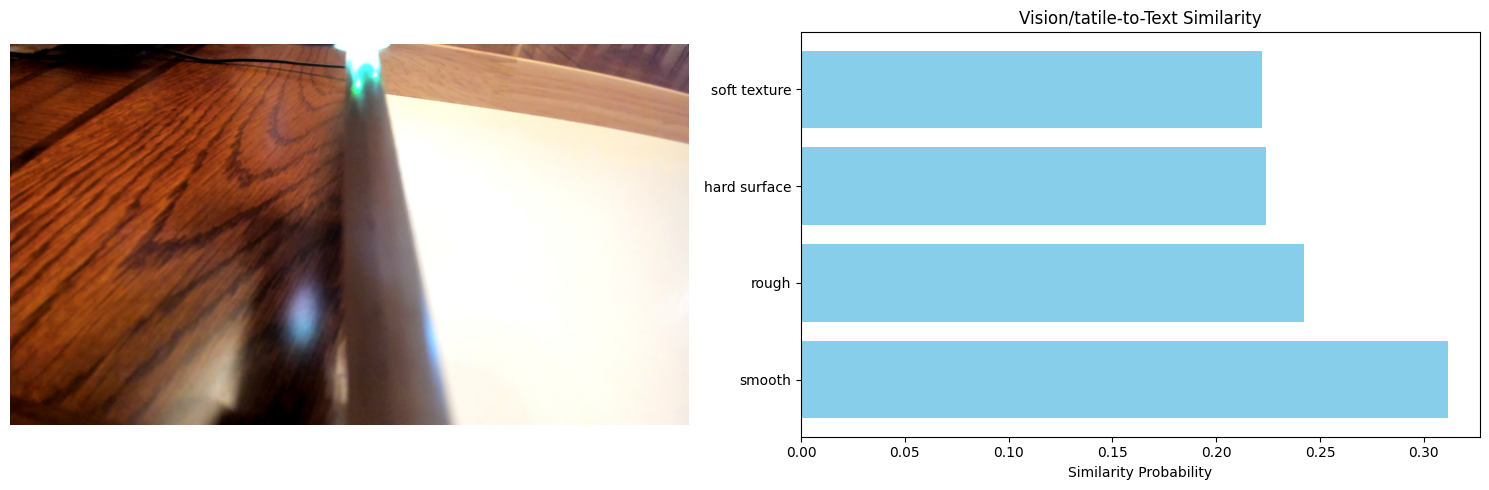

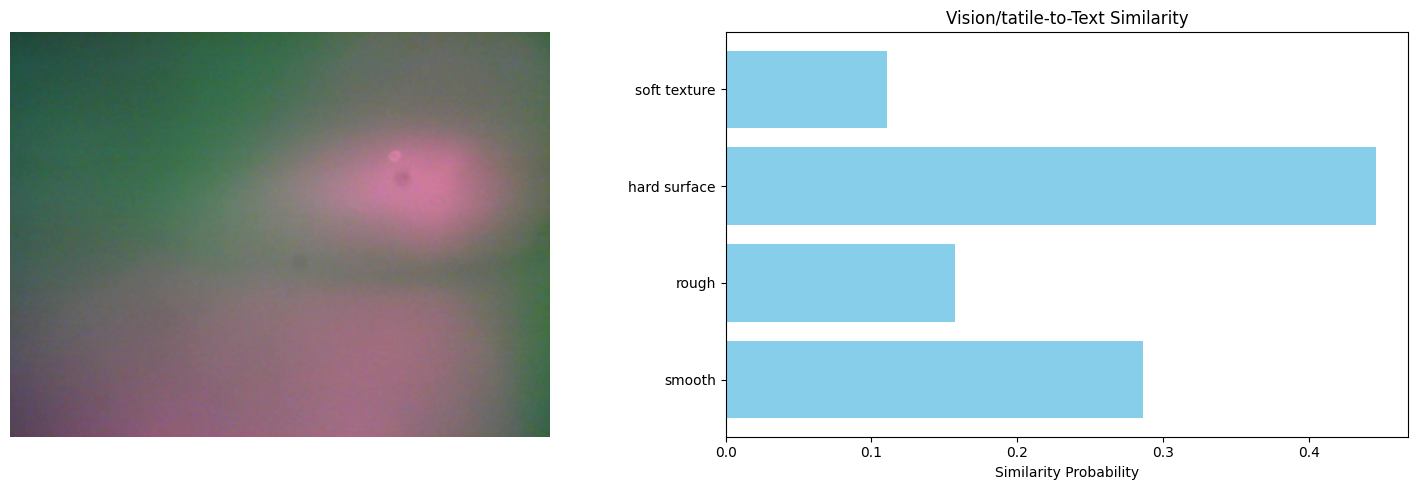

In [54]:
IMAGE_NAME = '158-0.03528618812561035'
TACTILE_IMAGE_PATH = "tactile/"+IMAGE_NAME+".jpg"
IMAGE_PATH = "image/"+IMAGE_NAME+".jpg"

# Define text labels, use all texts as text input for inference, to see which cosine similarity is the max.
texts = ["soft texture", "hard surface", "rough", "smooth"]
# Do inference
inference_on_image(TACTILE_IMAGE_PATH, IMAGE_PATH, texts, model_tvl)

In [55]:
model_tvl

TVL(
  (clip): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-23): 24 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ls_2): Identity()
          )
        )
   